# Mini proyecto #3 Page Rank

## Elaborado a manita por:
## Acosta Imandt Daniel
##Callejas Hernandez Edgar
## Garduño Martinez Eduardo

## Instalamos los modulos necesarios y los importamos.

In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.appName("demo") \
.config("spark.ui.port", "4050") \
.getOrCreate()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydot
import networkx as nx
from sklearn.preprocessing import Normalizer
from scipy import sparse
import seaborn as sns
spark = SparkSession.builder.appName('pagerank').getOrCreate()
sc=spark.sparkContext

# Cargamos datos

In [5]:
#Leemos los datos
data = pd.read_csv('web-NotreDame.txt',header = 3,delimiter='\t')
data

,# FromNodeId,ToNodeId
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
1497129,325727,1018
1497130,325727,325726
1497131,325727,325728
1497132,325728,1018


## Analisis de los Datos

In [6]:
#Guardamos los nodos con mas salidas
data_in = data.groupby(['# FromNodeId']).count().reset_index().sort_values(by=['ToNodeId'],axis=0,ascending=False)
data_in.rename(columns = {'# FromNodeId':'FromNodeId'}, inplace = True)
data_in

,FromNodeId,ToNodeId
4693,7137,3445
127847,289125,2660
127849,289128,2647
17226,32833,1893
17228,32835,1736
...,...,...
34607,86595,1
34606,86594,1
34605,86593,1
34599,86587,1


In [7]:
#Tomamos aleatoriamente n nodos
data_in2=data_in.sample(n=5794)


In [8]:
#Creamos la grafica
DG_comp = nx.DiGraph()
edges = zip(data_in2.FromNodeId,data_in2.ToNodeId)
DG_comp.add_edges_from(edges)

In [9]:
import seaborn as sns

In [11]:
#Guardamos los nodos con más entradas
data_out = data.groupby(['ToNodeId']).count().reset_index().sort_values('# FromNodeId',axis=0,ascending=False)
data_out

,ToNodeId,# FromNodeId
12129,12129,10721
0,0,7619
124802,124802,7026
31331,31331,4300
140170,140170,4279
...,...,...
142646,142646,1
142647,142647,1
142648,142648,1
142649,142649,1


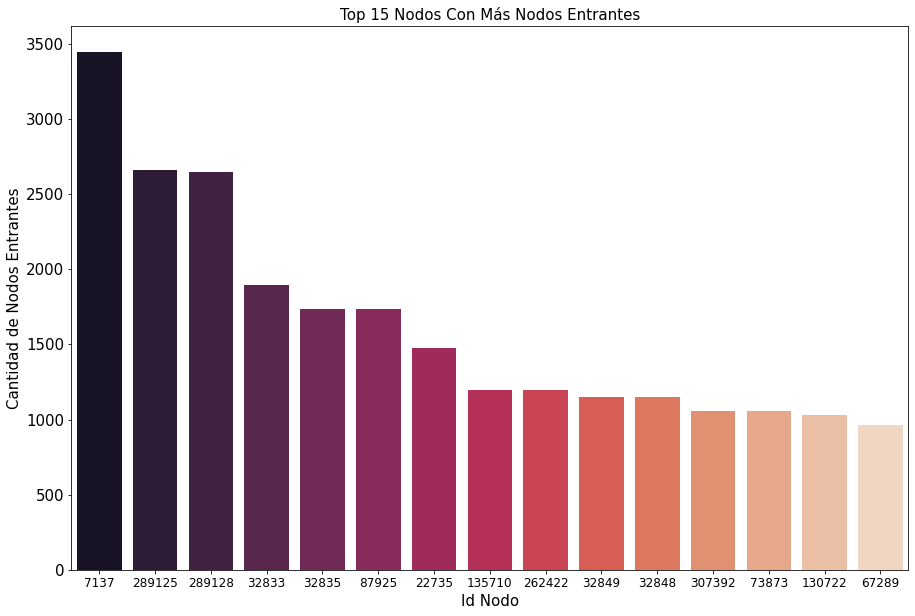

In [13]:
#Graficamos los datos anteriores
plt.figure(figsize=(15,10))
sns.barplot(data = data_in[:15],x='FromNodeId',y='ToNodeId',order=data_in.iloc[:15,0].values,palette='rocket')
plt.title('Top 15 Nodos Con Más Nodos Entrantes',fontsize=15)
plt.xlabel('Id Nodo',fontsize=15)
plt.ylabel('Cantidad de Nodos Entrantes',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.show()

## Procesamiento de los Datos

In [16]:
#Guardamos la lista de los nodos de entrada y salida
l1 = list(data.values[:,0])
l2 = list(data.values[:,1])

#Creamos el grafo
g = nx.DiGraph()

#Llenamos el grafo
for j,v in enumerate(l1):
    g.add_edge(v,l2[j])

#Guardamos los nodos y los ordenamos
nodes = list(g.nodes())
nodes.sort(reverse=False)

#Guardamos la matiz de adyacencia
m_ady = nx.adjacency_matrix(g,nodelist=nodes)

#Pasamos de la matriz de adyacencia a la matriz estocastica
norm = Normalizer(norm='l1')
M = norm.fit_transform(m_ady.T).T

In [37]:
print(len(l1))

1497134


## PageRank usando la función que toma callejones sin salida

In [17]:
def pagerank_escalable_ccs(M, beta=0.8,iter=20,show=False):
    
    #Inicializamos a r
    n = M.shape[0]
    r = np.ones((n,1)) / n
    
    #Guardamos en una lista un tupla de la forma (i,j,v) donde i el la fila, j la columna y v el valor en M de esas coordenadas
    filas_, columnas_ = M.nonzero()
    a = [(v,columnas_[j],M[v,columnas_[j]]) for j,v in enumerate(filas_)]
    
    #Paralelizamos a para poder usar map reduce
    rdd = sc.parallelize(a)
    
    #Realizamos las iteraciones indicaas
    for j in range(iter):
        if show:
            print('Iteración {0}: r = {1}'.format(j,r.T))
        
        #Inicializamos a r_hat como variable auxiliar
        r_hat = np.zeros((n,1))
    
        #Realizamos la operación de map
        mul_simple = rdd.map(lambda x: (x[0],x[2]*r[x[1],0]))
    
        #Realizamos la operación de reduce, especificamente reduce by key
        mul_suma = mul_simple.reduceByKey(lambda x,y : x+y)
    
    
        #Llenamos a r_hat con el resultado de la multiplicación
        for j in mul_suma.take(mul_suma.count()):
            r_hat[j[0]] = j[1]
            
        r_hat = beta*r_hat
            
        #Calculamos el otro termino
        umrsn = (1 - r_hat.sum()) / n
        
        #Llenamos a r
        r = r_hat + umrsn
        
    return r

In [18]:
def pagerank_escalable_css_profe(M, beta = 0.8, iter=20):
    n = M.shape[0]
    r = np.ones(n) / n
    for i in range(iter):
        #print('Iteración {0}: r = {1}'.format(i,r))
        rhat = beta * M @ r
        umrsn = (1 - rhat.sum()) / n
        r = rhat + umrsn

    return r

## PageRank sin usar la implementación sin caminos sin salida

In [19]:
def pagerank_escalable_noccs(M, beta=0.8,iter=20,show=False):
    
    #Inicializamos a r
    n = M.shape[0]
    r = np.ones((n,1)) / n
    
    #Guardamos en una lista un tupla de la forma (i,j,v) donde i el la fila, j la columna y v el valor en M de esas coordenadas
    filas_, columnas_ = M.nonzero()
    a = [(v,columnas_[j],M[v,columnas_[j]]) for j,v in enumerate(filas_)]
    
    #Paralelizamos a para poder usar map reduce
    rdd = sc.parallelize(a)
    
    #Realizamos las iteraciones indicaas
    for j in range(iter):
        if show:
            print('Iteración {0}: r = {1}'.format(j,r.T))
        
        #Inicializamos a r_hat como variable auxiliar
        r_hat = np.zeros((n,1))
    
        #Realizamos la operación de map
        mul_simple = rdd.map(lambda x: (x[0],x[2]*r[x[1],0]))
    
        #Realizamos la operación de reduce, especificamente reduce by key
        mul_suma = mul_simple.reduceByKey(lambda x,y : x+y)
    
    
        #Llenamos a r_hat con el resultado de la multiplicación
        for j in mul_suma.take(mul_suma.count()):
            r_hat[j[0]] = j[1]
            
        r_hat = beta*r_hat
            
        #Calculamos el otro termino
        umbn = (1 - beta) / n
        
        #Llenamos a r
        r = r_hat + umbn
        
    return r

In [20]:
def pagerank_escalable_nocss_profe(M, beta = 0.8, iter=100):
  n = M.shape[0]
  r = np.ones(n) / n
  umbn = (1 - beta) / n
  for i in range(iter):
    #print('Iteración {0}: r = {1}'.format(i,r))
    rhat = beta * M @ r
    r = rhat + umbn

  return r

## Resultados

### Con Callejones sin salida

In [21]:
#PageRank con callejones sin salida
X = pagerank_escalable_ccs(M,0.8,10) #Implementación propia
X_prof = pagerank_escalable_css_profe(M,0.8,10) #Implementación del profesor
X_prof = X_prof.reshape(X.shape)

diff = X - X_prof #Diferencia de los vectores entrada por entrada
print('La diferencia de los vectores se ve de la siguiente forma:')
diff

La diferencia de los vectores se ve de la siguiente forma:


array([[-2.71050543e-20],
       [-1.01643954e-20],
       [-1.05879118e-21],
       ...,
       [-7.62329653e-21],
       [-1.01643954e-20],
       [-5.50571416e-21]])

In [22]:
print('La suma de las diferencia de las entradas se ve de la siguiente forma:')
print(np.abs(diff).sum())
print(' ')
print('La norma de la diferencia de los vectores es la siguiente:')
print(np.linalg.norm(diff))

La suma de las diferencia de las entradas se ve de la siguiente forma:
5.480345096866212e-15
 
La norma de la diferencia de los vectores es la siguiente:
7.138450653826593e-16


### Sin callejones sin salida

In [23]:
#PageRank con callejones sin salida
X_2 = pagerank_escalable_noccs(M,0.8,10) #Implementación propia
X_prof_2 = pagerank_escalable_nocss_profe(M,0.8,10) #Implementación del profesor
X_prof_2 = X_prof_2.reshape(X_2.shape)

diff_2 = X_2 - X_prof_2 #Diferencia de los vectores entrada por entrada
print('La diferencia de los vectores se ve de la siguiente forma:')
diff_2

La diferencia de los vectores se ve de la siguiente forma:


array([[-6.77626358e-21],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       ...,
       [-1.69406589e-21],
       [-8.47032947e-22],
       [-1.27054942e-21]])

In [24]:
print('La suma de las diferencia de las entradas se ve de la siguiente forma:')
print(np.abs(diff_2).sum())
print(' ')
print('La norma de la diferencia de los vectores es la siguiente:')
print(np.linalg.norm(diff_2))

La suma de las diferencia de las entradas se ve de la siguiente forma:
4.551723500912654e-15
 
La norma de la diferencia de los vectores es la siguiente:
7.075008607958947e-16


### Network X

In [25]:
pr = nx.pagerank(g, alpha=0.80,max_iter=10, tol=1e-06)
pr

{0: 0.004745248246080977,
 1: 0.00035588471816053137,
 2: 0.00018957983649332526,
 3: 0.000283191539312535,
 4: 0.00023624456470258258,
 5: 0.00019074225513439195,
 6: 0.00019243429070961413,
 7: 0.00020361938259180924,
 8: 0.0001924105808365301,
 9: 0.0001930073718746805,
 10: 0.00018903586283949676,
 11: 0.0002001668384025366,
 12: 0.0001964942498320346,
 13: 0.00019507941217077304,
 14: 0.000617386383220275,
 15: 0.0002800964436258909,
 16: 0.00022516955352634338,
 17: 3.2293941168877355e-05,
 18: 3.6079632584490274e-05,
 19: 5.888411002130341e-05,
 20: 6.08487186063473e-05,
 21: 2.1053446141000503e-05,
 22: 7.957838396254372e-06,
 23: 1.6593267295445057e-05,
 24: 1.6282907439184776e-05,
 25: 1.695673372914664e-05,
 26: 7.957838396254372e-06,
 27: 1.6548962558827764e-05,
 28: 7.957838396254372e-06,
 29: 2.5478079613413798e-05,
 30: 7.957838396254372e-06,
 31: 7.957838396254372e-06,
 32: 1.2842292443906355e-05,
 33: 1.917039097930801e-05,
 34: 1.088689892001748e-05,
 35: 8.5612937040

In [26]:
data_ = {}
for llave,valor in pr.items():
    data_[llave] = [valor]

for j,v in enumerate(nodes):
    data_[v].append(X[j][0])
    data_[v].append(X_prof[j][0])
    data_[v].append(X_2[j][0])
    data_[v].append(X_prof_2[j][0])

resultados = pd.DataFrame.from_dict(data_,orient = 'index')
resultados.rename(columns={0: "Network X", 1: "CCS Propia", 2: 'CCS Profesor', 3: 'NO CCS Propia', 4: 'NO CCS Profesor'},inplace=True)
resultados

,Network X,CCS Propia,CCS Profesor,NO CCS Propia,NO CCS Profesor
0,0.004745,1.986714e-05,1.986714e-05,1.986714e-05,1.986714e-05
1,0.000356,1.019595e-05,1.019595e-05,1.019595e-05,1.019595e-05
2,0.000190,6.140073e-07,6.140073e-07,6.140073e-07,6.140073e-07
3,0.000283,7.150365e-06,7.150365e-06,7.150365e-06,7.150365e-06
4,0.000236,1.775133e-05,1.775133e-05,1.775133e-05,1.775133e-05
...,...,...,...,...,...
325724,0.000004,4.477998e-06,4.477998e-06,4.477998e-06,4.477998e-06
325725,0.000004,4.449393e-06,4.449393e-06,4.449393e-06,4.449393e-06
325726,0.000004,4.628528e-06,4.628528e-06,4.628528e-06,4.628528e-06
325727,0.000004,4.921520e-06,4.921520e-06,4.921520e-06,4.921520e-06


In [27]:
resultados_order = resultados.sort_values('CCS Propia',axis=0,ascending=False).reset_index()
resultados_order

,index,Network X,CCS Propia,CCS Profesor,NO CCS Propia,NO CCS Profesor
0,7137,0.000003,1.297165e-02,1.297165e-02,1.297165e-02,1.297165e-02
1,272565,0.000002,3.814559e-03,3.814559e-03,3.814559e-03,3.814559e-03
2,10334,0.000007,3.045465e-03,3.045465e-03,3.045465e-03,3.045465e-03
3,250132,0.000004,2.812538e-03,2.812538e-03,2.812538e-03,2.812538e-03
4,289128,0.000002,2.793247e-03,2.793247e-03,2.793247e-03,2.793247e-03
...,...,...,...,...,...,...
325724,42105,0.000002,6.140073e-07,6.140073e-07,6.140073e-07,6.140073e-07
325725,42104,0.000002,6.140073e-07,6.140073e-07,6.140073e-07,6.140073e-07
325726,42103,0.000003,6.140073e-07,6.140073e-07,6.140073e-07,6.140073e-07
325727,42102,0.000002,6.140073e-07,6.140073e-07,6.140073e-07,6.140073e-07


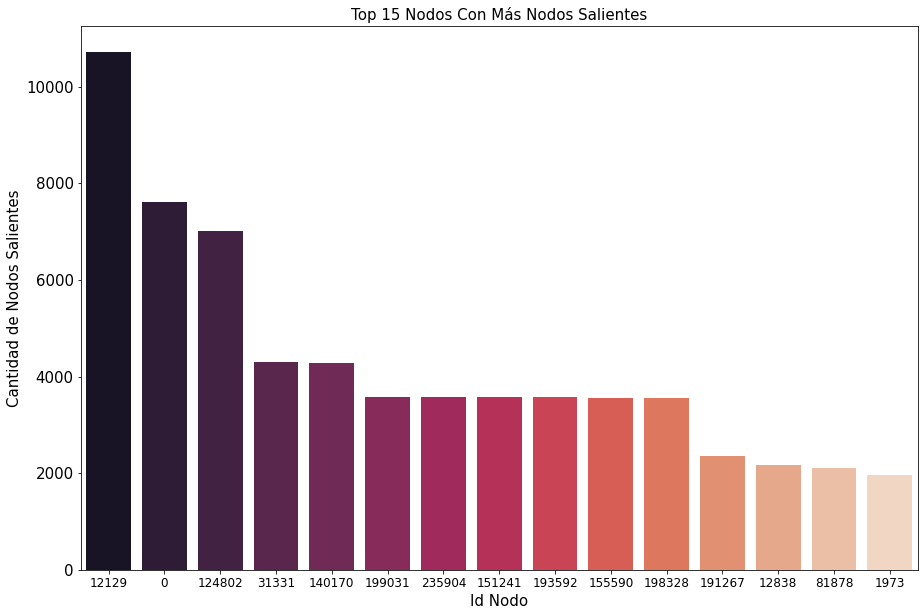

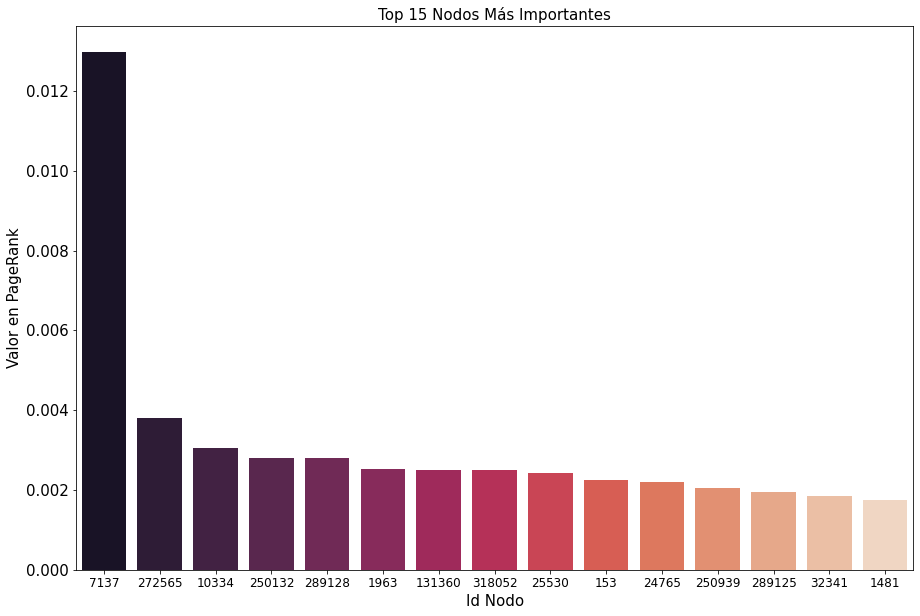

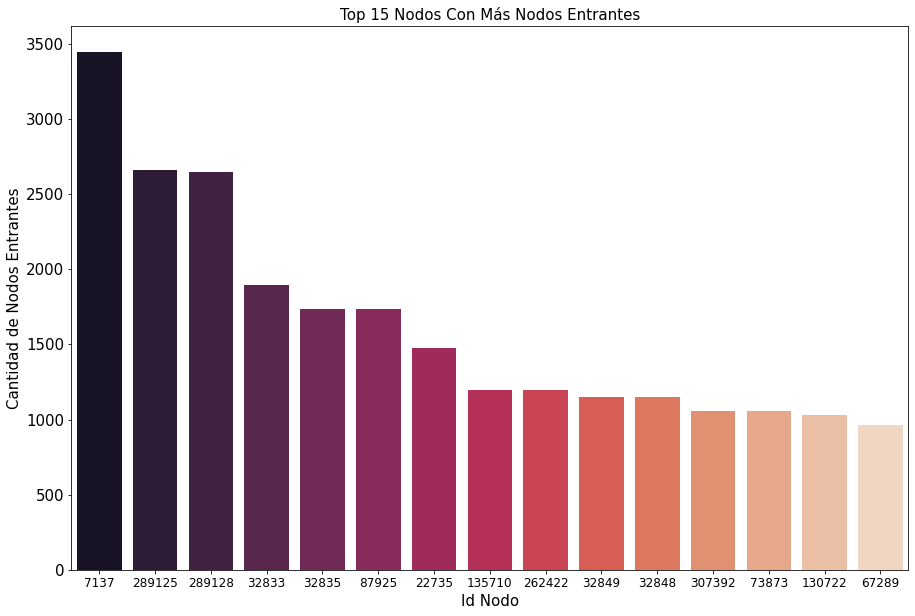

In [29]:
plt.figure(figsize=(15,10))
sns.barplot(data = data_out[:15],x='ToNodeId',y='# FromNodeId',order=data_out.iloc[:15,0].values,palette='rocket')
plt.title('Top 15 Nodos Con Más Nodos Salientes',fontsize=15)
plt.xlabel('Id Nodo',fontsize=15)
plt.ylabel('Cantidad de Nodos Salientes',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.show()

plt.figure(figsize=(15,10))
sns.barplot(data = resultados_order[:15],x='index',y='CCS Propia',order=resultados_order.iloc[:15,0].values,palette='rocket')
plt.title('Top 15 Nodos Más Importantes',fontsize=15)
plt.xlabel('Id Nodo',fontsize=15)
plt.ylabel('Valor en PageRank',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.show()

plt.figure(figsize=(15,10))
sns.barplot(data = data_in[:15],x='FromNodeId',y='ToNodeId',order=data_in.iloc[:15,0].values,palette='rocket')
plt.title('Top 15 Nodos Con Más Nodos Entrantes',fontsize=15)
plt.xlabel('Id Nodo',fontsize=15)
plt.ylabel('Cantidad de Nodos Entrantes',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.show()

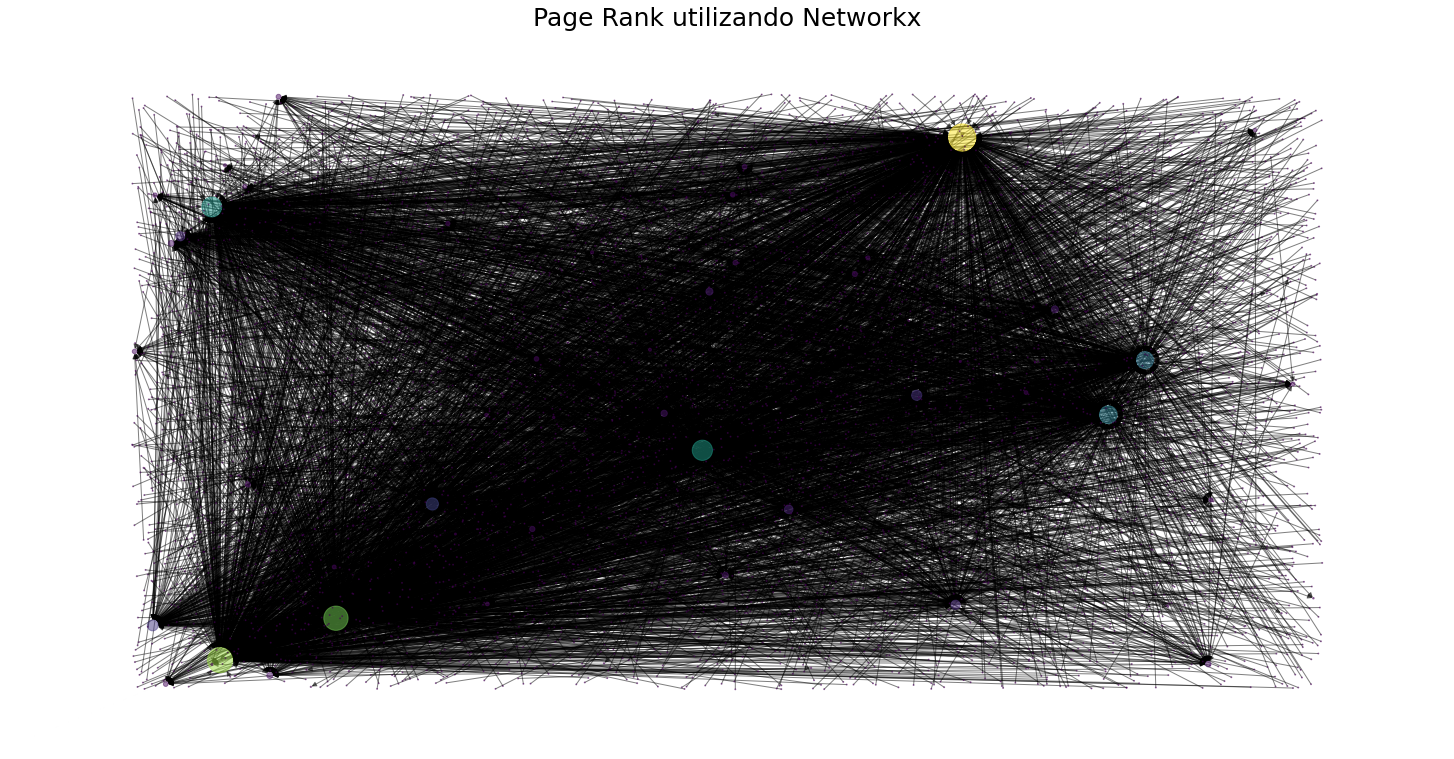

In [30]:
plt.figure(figsize = (20,10))
diccionario1 = nx.pagerank(DG_comp, alpha=0.9)
colors = np.array([diccionario1[i] for i in DG_comp])
nx.draw_random(DG_comp,
                       cmap = 'viridis',
               node_size=colors*10000,
                       node_color =colors,
                       alpha=0.5)
plt.title('Page Rank utilizando Networkx',fontdict={'size':25})
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: adj_matrix is deprecated and will be removed in version 3.0.
Use `adjacency_matrix` instead

  


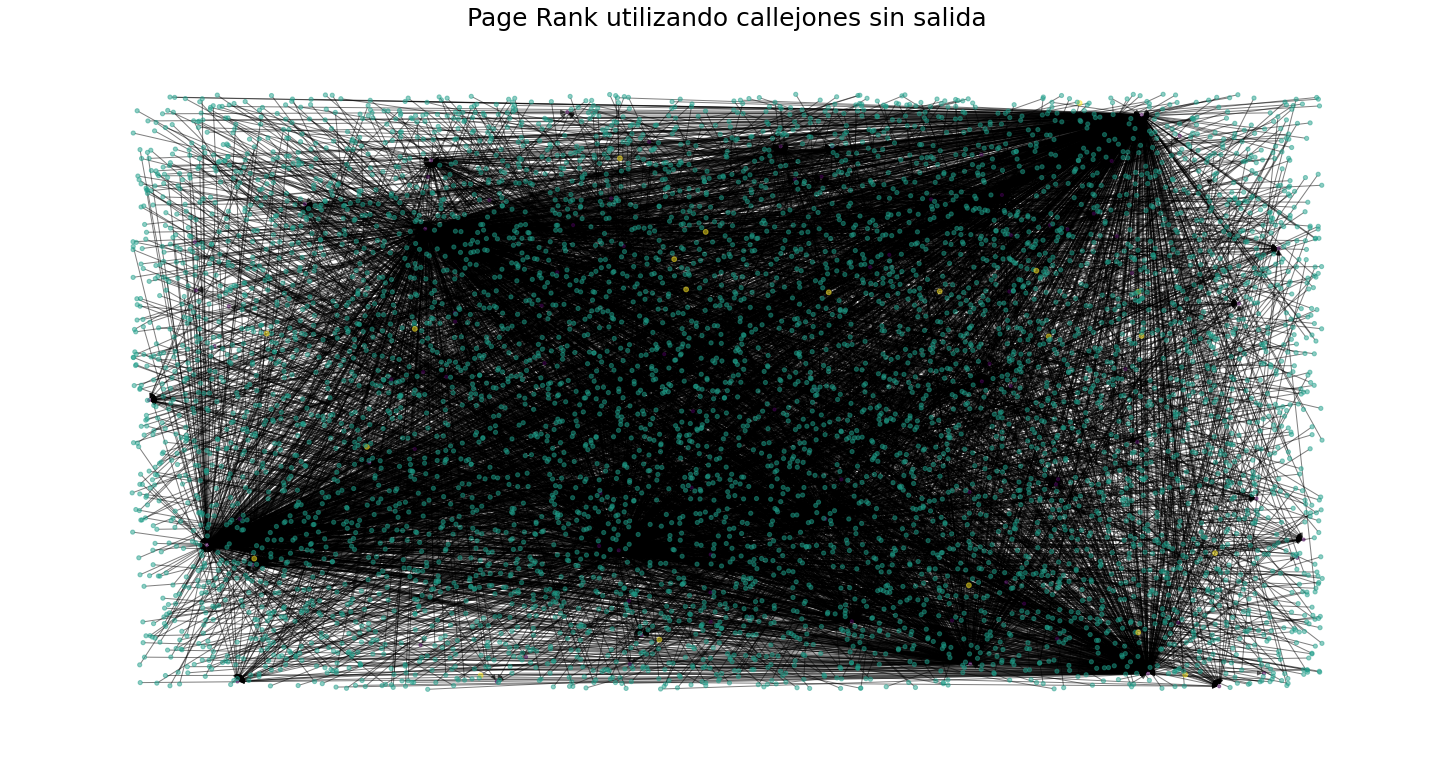

In [32]:

plt.figure(figsize = (20,10))
A=nx.adj_matrix(DG_comp)
colors =pagerank_escalable_ccs(A)
nx.draw_random(DG_comp,
                       cmap = 'viridis',
                       node_color =colors,
               node_size=colors*100000,
                       alpha=0.5)
plt.title('Page Rank utilizando callejones sin salida',fontdict={'size':25})
plt.show()